In [1]:
from scipy.fft import fft, ifft

import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
EXPOSURE_ANALYSIS = "Exposure Analysis"
EXPERIENCE_ANALYSIS = "Experience Analysis"
TRIANGULAR_ANALYSIS = "Triangular Analysis"

# intervals to calculate mean of distribution
MEAN_INTERVALS = 1000

# FFT values
ALMOST_ZERO = 4e-16
START_VALUE_CONVOLUTION = 0.0
BOTTOM_QUANTILE = 0.0001
TOP_QUANTILE = 0.9999
BUFFER = 2.1

STEPS = 1_000
FFT_STEPS = 10_000

# Plot parameters
PLOT_TOP_QUANTILE = 0.995
PLOT_STEPS = 1000


In [3]:
import logging
import math
from abc import ABC, abstractmethod, abstractstaticmethod

import numpy as np
from scipy.stats import binom, gamma, loggamma, lognorm, nbinom, norm, pareto, poisson

class Distribution(ABC):
    @abstractmethod
    def cdf(self, x):
        pass

    @abstractmethod
    def ppf(self, q):
        pass

    def sf(self, x):
        """Survival function, 1 - cdf(x)"""
        return 1 - self.cdf(x)

    def las(self, d: float) -> float:
        # TODO: vectorize this
        start = int(min(self.bottom_quantile_or_min(), 0))
        end = int(self.top_quantile_or_max())
        step = max((end - start) // 2000, 1)
        return sum(
            (
                (self.cdf(s + step / 2.0) - self.cdf(s - step / 2.0)) * min(s, d)
                for s in range(start, end, step)
            )
        )

    def mean_and_variance_in_layer(self, retention: float, limit: float) -> float:
        start = int(min(self.bottom_quantile_or_min(), 0))
        end = int(self.top_quantile_or_max())
        step = max((end - start) // 2000, 1)

        steps = np.arange(start, end, step)
        valid_steps = steps[steps - retention > 0]

        pdf_differences = self.cdf(valid_steps + step / 2.0) - self.cdf(
            valid_steps - step / 2.0
        )

        adjusted_values = np.minimum(valid_steps - retention, limit)

        mean = np.sum(pdf_differences * adjusted_values)

        variance = np.sum(pdf_differences * (adjusted_values - mean) ** 2)

        return mean, variance

    @abstractstaticmethod
    def is_discrete():
        pass

    @abstractmethod
    def max_value(self) -> float:
        pass

    @abstractmethod
    def min_value(self) -> float:
        pass

    def __str__(self) -> str:
        return self.__class__.__name__

    @abstractstaticmethod
    def distribution_type():
        pass

    @abstractstaticmethod
    def display_name():
        pass

    @abstractstaticmethod
    def variables() -> list[str]:
        pass

    def parameters(self):
        return {
            str.capitalize(v): getattr(
                self, v.removeprefix(f"{self.distribution_type()}_")
            )
            for v in self.variables()
        }

    def display_parameters(self):
        return {
            (variable := v.removeprefix(f"{self.distribution_type()}_")): display_value(
                getattr(self, variable), significant=5
            )
            for v in self.variables()
        }

    def bottom_quantile_or_min(self, quantile=BOTTOM_QUANTILE) -> float:
        return m if not math.isinf((m := self.min_value())) else self.ppf(quantile)

    def top_quantile_or_max(self, quantile=TOP_QUANTILE) -> float:
        return m if not math.isinf((m := self.max_value())) else self.ppf(quantile)


class Undefined:

    @staticmethod
    def distribution_type():
        return "undefined"

    @staticmethod
    def display_name():
        return UNDEFINED

    @staticmethod
    def variables():
        return []


class Poisson(Distribution):
    def __init__(self, poisson_rate: float):
        if poisson_rate <= 0:
            raise ValueError("rate must be greater than 0")
        self.rate = poisson_rate

    def mgf(self, x):
        return math.exp(self.rate * (math.exp(x) - 1))

    def pgf(self, x):
        return np.exp(self.rate * (x - 1))

    def cdf(self, x):
        return poisson.cdf(x, self.rate)

    def ppf(self, q):
        return poisson.ppf(q, self.rate)

    def pmf(self, x):
        return poisson.pmf(x, self.rate)

    def mean(self):
        return self.rate

    def panjer_parameters(self):
        # Returns the parameters p_0, a, b of the Panjer recursion
        return [self.cdf(0), 0, self.rate]

    def max_value(self) -> float:
        return float("inf")

    def min_value(self) -> float:
        return 0

    @staticmethod
    def is_discrete():
        return True

    @staticmethod
    def distribution_type():
        return "poisson"

    @staticmethod
    def display_name():
        return "Poisson"

    @staticmethod
    def variables():
        return ["poisson_rate"]


class Binomial(Distribution):
    def __init__(self, binomial_p: float, binomial_n: int):
        if binomial_p <= 0 or binomial_p > 1:
            raise ValueError("p must be between 0 and 1")
        if binomial_n <= 0 or not isinstance(binomial_n, int):
            raise ValueError("n must bean integer greater than 0")
        self.p = binomial_p
        self.n = binomial_n

    def mgf(self, x):
        return (1 - self.p + self.p * np.exp(x)) ** self.n

    def pgf(self, x):
        return (1 - self.p + self.p * x) ** self.n

    def cdf(self, x):
        return binom.cdf(x, self.n, self.p)

    def ppf(self, q):
        return binom.ppf(q, self.n, self.p)

    def pmf(self, x):
        return poisson.pmf(x, self.rate)

    def mean(self):
        return self.n * self.p

    def panjer_parameters(self):
        # Returns the parameters p_0, a, b of the Panjer recursion
        return [
            self.cdf(0),
            -self.p / (1 - self.p),
            self.p * (self.n + 1) / (1 - self.p),
        ]

    def max_value(self) -> float:
        return self.n

    def min_value(self) -> float:
        return 0

    @staticmethod
    def is_discrete():
        return True

    @staticmethod
    def distribution_type():
        return "binomial"

    @staticmethod
    def display_name():
        return "Binomial"

    @staticmethod
    def variables():
        return ["binomial_p", "binomial_n"]


class NegativeBinomial(Distribution):
    def __init__(self, negativebinomial_p: float, negativebinomial_r: int):
        if negativebinomial_p <= 0 or negativebinomial_p >= 1:
            raise ValueError("p must be between 0 and 1")
        if negativebinomial_r <= 0:
            raise ValueError("r must be greater than 0")
        self.p = negativebinomial_p
        self.r = negativebinomial_r

    def mgf(self, x):
        return (self.p / (1 - math.exp(x) + self.p * math.exp(x))) ** self.r

    def pgf(self, x):
        return (self.p / (1 - x + self.p * x)) ** self.r

    def cdf(self, x):
        return nbinom.cdf(x, self.r, self.p)

    def ppf(self, q):
        return nbinom.ppf(q, self.r, self.p)

    def pmf(self, x):
        return poisson.pmf(x, self.rate)

    def mean(self):
        return self.r * (1 - self.p) / self.p

    def panjer_parameters(self):
        # Returns the parameters p_0, a, b of the Panjer recursion
        return [self.cdf(0), 1 - self.p, (1 - self.p) * (self.r - 1)]

    def max_value(self):
        return float("inf")

    def min_value(self):
        return 0

    @staticmethod
    def is_discrete():
        return True

    @staticmethod
    def distribution_type():
        return "negativebinomial"

    @staticmethod
    def display_name():
        return "Negative-binomial"

    @staticmethod
    def variables():
        return ["negativebinomial_p", "negativebinomial_r"]


class Normal(Distribution):
    def __init__(self, normal_mu: float, normal_sigma: float) -> None:
        if normal_sigma <= 0:
            raise ValueError("sigma must be greater than 0")
        self.mu = normal_mu
        self.sigma = normal_sigma

    def mgf(self, x):
        return math.exp(self.mu * x + 0.5 * self.sigma**2 * x**2)

    def cdf(self, x):
        return norm.cdf(x, self.mu, self.sigma)

    def ppf(self, q):
        return norm.ppf(q, self.mu, self.sigma)

    def max_value(self):
        return float("inf")

    def min_value(self):
        return float("-inf")

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "normal"

    @staticmethod
    def display_name():
        return "Normal"

    @staticmethod
    def variables():
        return ["normal_mu", "normal_sigma"]


class LogNormal(Distribution):
    def __init__(self, lognormal_mu: float, lognormal_sigma: float) -> None:
        if lognormal_sigma <= 0:
            raise ValueError("sigma must be greater than 0")
        self.mu = lognormal_mu
        self.sigma = lognormal_sigma

    def cdf(self, x):
        return lognorm.cdf(x, s=self.sigma, scale=math.exp(self.mu), loc=0)

    def ppf(self, q):
        return lognorm.ppf(q, s=self.sigma, scale=math.exp(self.mu), loc=0)

    def pdf(self, x):
        return lognorm.pdf(x, s=self.sigma, scale=math.exp(self.mu), loc=0)

    @staticmethod
    def is_discrete():
        return False

    def max_value(self):
        return float("inf")

    def min_value(self):
        return 0.0

    @staticmethod
    def distribution_type():
        return "lognormal"

    @staticmethod
    def display_name():
        return "Log-normal"

    @staticmethod
    def variables():
        return ["lognormal_mu", "lognormal_sigma"]


class Gamma(Distribution):
    def __init__(self, gamma_shape: float, gamma_rate: float, gamma_location=0):
        self.shape = gamma_shape
        self.rate = gamma_rate
        self.location = gamma_location
        self.scale = 1 / self.rate

    def cdf(self, x):
        return gamma.cdf(x, self.shape, loc=self.location, scale=self.scale)

    def ppf(self, q):
        return gamma.ppf(q, self.shape, loc=self.location, scale=self.scale)

    def pdf(self, x):
        return gamma.pdf(x, self.shape, loc=self.location, scale=self.scale)

    @staticmethod
    def is_discrete():
        return False

    def max_value(self):
        return float("inf")

    def min_value(self):
        return 0.0 + self.location

    @staticmethod
    def distribution_type():
        return "gamma"

    @staticmethod
    def display_name():
        return "Gamma"

    @staticmethod
    def variables():
        return ["gamma_shape", "gamma_rate", "gamma_location"]


class LogGamma(Distribution):
    """
    The loggamma distribution is defined by the shape, rate and location parameters.
    The location parameter is optional and defaults to 0.
    The distribution is 0 below 1 + threshold.

    We use the gamma function from scipy.stats, since the loggamma defined there
    is in reality the expgamma function, see Wolfram pages for the definition
    """

    def __init__(
        self, loggamma_shape: float, loggamma_rate: float, loggamma_location=0
    ):
        self.shape = loggamma_shape
        self.rate = loggamma_rate
        self.scale = 1.0 / self.rate
        self.location = loggamma_location

    def cdf(self, x):
        x = np.array(x, dtype=float)
        cdf_values = np.zeros_like(x)
        valid_indices = x > 1 + self.location
        cdf_values[valid_indices] = gamma.cdf(
            np.log(x[valid_indices] - self.location), self.shape, scale=self.scale
        )
        if np.isscalar(x) or np.array(x).ndim == 0:
            return cdf_values.item()
        else:
            return cdf_values

    def ppf(self, q):
        value = gamma.ppf(q, self.shape, scale=self.scale)
        return math.exp(value) + self.location

    def pdf(self, x):
        if x < 1 + self.location:
            return 0
        z = x - self.location
        return gamma.pdf(math.log(z), self.shape, scale=self.scale) / z

    def max_value(self) -> float:
        return float("inf")

    def min_value(self) -> float:
        return 1.0 + self.location

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "loggamma"

    @staticmethod
    def display_name():
        return "Log-gamma"

    @staticmethod
    def variables():
        return ["loggamma_shape", "loggamma_rate", "loggamma_location"]


class Pareto(Distribution):
    def __init__(self, pareto_scale: float, pareto_shape: float) -> None:
        if pareto_shape <= 0:
            raise ValueError("shape must be greater than 0")
        self.scale = pareto_scale
        self.shape = pareto_shape

    def cdf(self, x):
        return pareto.cdf(x, self.shape, scale=self.scale)

    def ppf(self, q):
        return pareto.ppf(q, self.shape, scale=self.scale)

    def pdf(self, x):
        return pareto.pdf(x, self.shape, scale=self.scale)

    def max_value(self):
        return float("inf")

    def min_value(self):
        return self.scale

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "pareto"

    @staticmethod
    def display_name():
        return "Pareto"

    @staticmethod
    def variables():
        return ["pareto_scale", "pareto_shape"]


class PiecewisePareto(Distribution):
    def __init__(
        self,
        piecewisepareto_thresholds: list[float],
        piecewisepareto_alphas: list[float],
    ) -> None:
        self.thresholds = np.array(piecewisepareto_thresholds)
        self.alphas = np.array(piecewisepareto_alphas)
        steps = (self.thresholds[:-1] / self.thresholds[1:]) ** self.alphas[:-1]
        self.cum_steps = np.concatenate(([1], np.cumprod(steps)))

    def cdf(self, x):
        x = np.array(x, dtype=float)
        cdf_values = np.zeros_like(x)

        # Process each threshold
        for i, threshold in enumerate(self.thresholds[:-1]):
            mask = (x > threshold) & (x <= self.thresholds[i + 1])
            cdf_values[mask] = (
                1 - (self.thresholds[i] / x[mask]) ** self.alphas[i] * self.cum_steps[i]
            )

        # Handle last threshold separately
        last_mask = x > self.thresholds[-1]
        cdf_values[last_mask] = (
            1
            - (self.thresholds[-1] / x[last_mask]) ** self.alphas[-1]
            * self.cum_steps[-1]
        )

        # Values below the first threshold
        cdf_values[x <= self.thresholds[0]] = 0

        # Return the appropriate type based on input
        if np.isscalar(x) or np.array(x).ndim == 0:
            return cdf_values.item()
        else:
            return cdf_values

    def ppf(self, q):
        if q < 0 or q > 1:
            raise ValueError("q must be between 0 and 1")
        if q == 0:
            return float("-inf")
        if q == 1:
            return float("inf")
        ps = [self.cdf(t) for t in self.thresholds]
        k = len([p for p in ps if p < q]) - 1
        t_k = self.thresholds[k]
        x = t_k * ((1 - self.cdf(t_k)) / (1 - q)) ** (1 / self.alphas[k])
        return x

    def max_value(self) -> float:
        return float("inf")

    def min_value(self) -> float:
        return self.thresholds[0]

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "piecewisepareto"

    @staticmethod
    def display_name():
        return "Piecewise Pareto"

    @staticmethod
    def variables():
        return ["piecewisepareto_thresholds", "piecewisepareto_alphas"]

    def display_parameters(self):
        return {
            "Thresholds": ",".join(
                [display_value(t, decimals=0) for t in self.thresholds]
            ),
            "Alphas": ",".join([display_value(a, decimals=4) for a in self.alphas]),
        }


class Mbbefd(Distribution):
    """
    The MBBEFD is a distribution that is used to model the severity of losses.
    It is defined by two parameters b and g.
    """

    def __init__(self, mbbefd_b: float, mbbefd_g: float) -> None:
        self.b = mbbefd_b
        self.g = mbbefd_g

    def cdf(self, x):
        was_scalar_input = np.isscalar(x)
        x = np.array(x, dtype=float)

        b, g = self.b, self.g
        if g == 1 or b == 0:
            result = x
        elif b == 1 and g > 1:
            result = np.log(1 + (g - 1) * x) / np.log(g)
        elif b * g == 1 and g > 1:
            result = (1 - np.power(b, x)) / (1 - b)
        elif (b > 1 and b != 1) or b * g != 1 and g > 1:
            result = np.log(
                ((g - 1) * b + (1 - g * b) * np.power(b, x)) / (1 - b)
            ) / np.log(g * b)
        else:
            raise ValueError("Invalid parameters")

        return result.item() if was_scalar_input else result

    def g_deriv(self, x) -> float:
        # Derivative of the cdf, used as help function, see Bernegger paper
        b, g = self.b, self.g
        if g == 1 or b == 0:
            return 1
        if b == 1 and g > 1:
            return (g - 1) / (math.log(g) * (1 + (g - 1) * x))
        if b * g == 1 and g > 1:
            return math.log(b) * math.pow(b, x) / (b - 1)
        if (b > 1 and b != 1) or b * g != 1 and g > 1:
            return (
                math.log(b)
                * (1 - g * b)
                / (math.log(g * b) * ((g - 1) * math.pow(b, 1 - x) + (1 - g * b)))
            )
        raise ValueError("Invalid parameters")

    def probability_exceeding_percentage(self, d: float) -> float:
        """
        Returns the probability to have a loss greater than d.

        This is NOT the probability of having a loss greater than d,
        given that there is a loss.

        This is 1 - F(d) where F is the cdf of the distribution
        underlying the exposure curve.
        """
        if d < 0 or d >= 1:
            raise ValueError("d must be greater than 0")
        return self.g_deriv(d) / self.g_deriv(0)

    def las(self, d: float) -> float:
        """
        Limited average severity, i.e. E[min(loss, d)]
        """
        return self.cdf(d) / self.g_deriv(0)

    def ppf(self, q):
        raise NotImplementedError("ppf not implemented for MBBEFD")

    def max_value(self) -> float:
        return 1.0

    def min_value(self) -> float:
        return 0.0

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "mbbefd"

    @staticmethod
    def display_name():
        return "MBBEFD"

    @staticmethod
    def variables():
        return ["mbbefd_b", "mbbefd_g"]


class Psold(Distribution):
    def __init__(self, *args):
        if len(args) != 8:
            raise ValueError(
                f"Psold needs 8 parameters, only {len(args)} were provided"
            )
        self.weights = args
        self.coefficients = self.calc_coefficients()

    def calc_coefficients(self):
        return [10 ** (0.5 * (i + 1)) for i in range(2, 10)]

    def las(self, d: float) -> float:
        """
        Limited average severity, i.e. E[min(loss, d)]
        """
        return sum(
            [
                self.weights[i]
                * self.coefficients[i]
                * (1 - math.exp(-d / self.coefficients[i]))
                for i in range(8)
            ]
        )

    def cdf(self, x):
        raise NotImplementedError("cdf not implemented for Psold")

    def ppf(self, q):
        raise NotImplementedError("cdf not implemented for Psold")

    def max_value(self) -> float:
        return float("inf")

    def min_value(self) -> float:
        return 0.0

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "psold"

    @staticmethod
    def display_name():
        return "PSOLD"

    @staticmethod
    def variables():
        return ["psold_occupancy_class", "psold_peril", "psold_aoi"]


class Ecdf(Distribution):
    """
    The observations are provided in the form
    [(value_1, weight_1), (value_2, weight_2), (value_3, weight_3)]
    The weights are normalized to sum to 1
    """

    def __init__(self, ecdf_observations: list):
        observations_array = np.array(ecdf_observations)

        if np.any(observations_array[:, 1] < -ALMOST_ZERO):
            negative_values = observations_array[
                observations_array[:, 1] < -ALMOST_ZERO
            ]
            logger.error(f"Negative values found: {negative_values}")
            raise ValueError("Weights must be non-negative")

        cleaned_weights = np.maximum(observations_array[:, 1], 0)
        total_weight = np.sum(cleaned_weights)

        if total_weight <= ALMOST_ZERO:
            raise ValueError("Total weight cannot be zero or too close to it")

        normalized_weights = cleaned_weights / total_weight
        sorted_indices = np.argsort(observations_array[:, 0])
        self.values = observations_array[sorted_indices, 0]
        pdf_values = normalized_weights[sorted_indices]
        self.cdf_values = np.cumsum(pdf_values)
        self._observations = np.column_stack((self.values, pdf_values))

    def get_observations(self) -> list[tuple[float, float]]:
        return [tuple(obs) for obs in self._observations.tolist()]

    def cdf(self, x, method="scaled"):
        if method == "scaled":
            if np.isscalar(x):
                index = np.searchsorted(self.values, x, side="right")
                return self.cdf_values[index - 1] if index > 0 else 0
            index = np.searchsorted(self.values, x, side="right")
            mask = index > 0
            result = np.where(mask, self.cdf_values[index - 1], 0)
            return result

        elif method == "linear":
            if np.isscalar(x):
                x = np.array([x], dtype=float)  # Scalar to array for uniform processing
            else:
                x = np.array(x, dtype=float)

            # Edge cases
            cdf_values = np.zeros_like(x)
            cdf_values[x >= self.values[-1]] = 1

            # Linear interpolation for values within the observations range
            indices = np.searchsorted(self.values, x, side="right") - 1
            indices = np.clip(indices, 0, len(self.cdf_values) - 1)

            within_bounds_mask = (x >= self.values[0]) & (x < self.values[-1])
            x_within_bounds = x[within_bounds_mask]
            indices_within_bounds = indices[within_bounds_mask]

            dx = x_within_bounds - self.values[indices_within_bounds]
            dy = (
                self.cdf_values[indices_within_bounds + 1]
                - self.cdf_values[indices_within_bounds]
            )
            slopes = dy / (
                self.values[indices_within_bounds + 1]
                - self.values[indices_within_bounds]
            )

            cdf_values[within_bounds_mask] = (
                self.cdf_values[indices_within_bounds] + slopes * dx
            )

            return cdf_values if len(cdf_values) > 1 else cdf_values[0]

        else:
            raise ValueError(f"Unknown method {method}")

    def ppf(self, q, method="linear"):
        if q < 0 or q > 1:
            raise ValueError("q must be between 0 and 1")
        if method == "linear":
            if q == 0:
                return self.values[0]

            if q <= self.cdf_values[0]:
                return self.values[0]
            v = 0
            for i, (x, prob) in enumerate(self._observations):
                if v + prob > q:
                    precedent = self.values[i - 1]
                    return precedent + ((q - v) / prob) * (x - precedent)
                v += prob
            return self.values[-1]

        else:
            b = 0
            for e in self._observations:
                if b + e[1] >= q:
                    return e[0]
                b += e[1]
            return self.values[-1]

    def max_value(self) -> float:
        return self.values[-1]

    def min_value(self) -> float:
        return self.values[0]

    def mean(self) -> float:
        return sum([obs * prob for (obs, prob) in self._observations])

    def las(self, d: float) -> float:
        """
        Limited average severity, i.e. E[min(loss, d)]
        """
        return sum([min(obs, d) * prob for (obs, prob) in self._observations])

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "ecdf"

    @staticmethod
    def display_name():
        return "Empirical CDF"

    @staticmethod
    def variables():
        return ["ecdf_observations"]

    @staticmethod
    def is_discrete():
        return False

    @staticmethod
    def distribution_type():
        return "ecdf"

    @staticmethod
    def display_name():
        return "Empirical CDF"

    @staticmethod
    def variables():
        return ["ecdf_observations"]

    def parameters(self):
        return {"ecdf_observations": self.get_observations()}


class RefittedDistribution(Distribution):
    def __init__(
        self,
        distribution: Distribution,
        scale: float = 1.0,
        retention: float = 0.0,
        limit: float = float("inf"),
    ):
        self.distribution = distribution
        self.scale = scale
        self.retention = retention
        self.limit = limit

    def display_name(self):
        return f"{self.distribution.display_name()} limited to [{self.retention}, {self.limit}]"

    def distribution_type(self):
        return f"limited{self.distribution.distribution_type()}"

    def variables(self):
        return [f"limited_{v}" for v in self.distribution.variables()]

    def cdf(self, x):
        x = np.array(x, dtype=float)
        cdf_values = np.zeros(x.shape, dtype=float)
        condition_min = x < self.min_value()
        condition_max = x > self.max_value()
        cdf_values[condition_min] = 0
        cdf_values[condition_max] = 1
        within_range = ~(condition_min | condition_max)
        cdf_values[within_range] = self.distribution.cdf(
            (x[within_range] + self.retention) / self.scale
        )
        if np.isscalar(x) or np.array(x).ndim == 0:
            return cdf_values.item()  # Converts a 0-dimensional array to a scalar
        else:
            return cdf_values

    def ppf(self, q):
        if q < 0 or q > 1:
            raise ValueError("q must be between 0 and 1")
        v = self.distribution.ppf(q) * self.scale - self.retention
        if v < self.min_value():
            return self.min_value()
        if v > self.max_value():
            return self.max_value()
        return v

    def las(self, d: float) -> float:
        pass

    def max_value(self):
        return min(
            self.limit,
            self.distribution.max_value() * self.scale - self.retention,
        )

    def min_value(self):
        return max(
            0,
            self.distribution.min_value() * self.scale - self.retention,
        )

    def is_discrete(self):
        return self.distribution.is_discrete()

In [4]:
class ConvolutionPlan:

    def __init__(self, start_at, end_at, steps):
        self.grid = np.linspace(start_at, end_at, steps)

    @classmethod
    def for_freq_sev(
        cls, frequency, severity, steps: int = FFT_STEPS
    ):
        severity_min = severity.bottom_quantile_or_min()
        if severity_min < 0:
            logger.error("Severity distribution must be positive")
            raise ValueError("Severity distribution must be positive")
        start_at = 0
        max_severity = severity.top_quantile_or_max()
        avg_severity = severity.ppf(0.5)
        max_frequency = frequency.top_quantile_or_max()
        avg_frequency = frequency.ppf(0.5)
        end_at = max(max_severity * avg_frequency, avg_severity * max_frequency)
        buffer = (end_at - start_at) * BUFFER  # TODO: not statisfactory
        return cls(start_at, end_at + buffer, steps)

    @classmethod
    def for_distributions(
        cls, *args, steps: int = FFT_STEPS, buffer=BUFFER
    ):
        if len(args) == 0:
            logger.error("At least one distribution must be provided")
            raise ValueError("At least one distribution must be provided")
        mins = [d.bottom_quantile_or_min() for d in args]
        maxs = [d.top_quantile_or_max() for d in args]
        start_at = sum((m if m < 0 else 0 for m in mins))
        end_at = sum((m if m > 0 else 0 for m in maxs))
        bffr = (end_at - start_at) * buffer  # TODO: not statisfactory
        return cls(start_at, end_at + bffr, steps)

    @classmethod
    def new_for_distributions(
        cls, *args, steps: int = FFT_STEPS, buffer=BUFFER
    ):
        if len(args) == 0:
            logger.error("At least one distribution must be provided")
            raise ValueError("At least one distribution must be provided")
        mins = [d.bottom_quantile_or_min(quantile=1e-6) for d in args]
        maxs = [d.top_quantile_or_max(quantile=1 - 1e-6) for d in args]
        start_at = min((m for m in mins))
        end_at = max((m for m in maxs))
        upper_bffr = (end_at - start_at) * len(args)  # TODO: not statisfactory
        lower_bffr = (end_at - start_at) * 0  # TODO: not statisfactory
        return cls(start_at - lower_bffr, end_at + upper_bffr, steps)

    def discretize(self, d) -> np.ndarray:
        cdf_values = d.cdf(self.grid)
        differences = np.diff(cdf_values)
        return differences

    def construct_observations(
        self, weights: np.ndarray, ref_points: str, shift: int = 1
    ) -> list[tuple[float, float]]:
        if ref_points == "upper":
            grid = self.grid[1:]
        elif ref_points == "lower":
            grid = self.grid[:-1]
        elif ref_points == "middle":
            grid = (self.grid[1:] + self.grid[:-1]) / 2
        else:
            raise ValueError(f"Unknown ref_points: {ref_points}")
        points = grid + shift * self.grid[0]  # TODO: investigate why this is necessary

        obs = list(zip(points, weights, strict=True))
        return obs

    def expandedgrid_ref_points(self, ref_points: str) -> list[float]:
        expandedgrid = np.linspace(
            self.grid[0] * 2, self.grid[-1] * 2, len(self.grid) * 2 - 1
        )
        if ref_points == "upper":
            grid = expandedgrid[1:-1]  # TODO: investigate why this is necessary
        elif ref_points == "lower":
            grid = expandedgrid[:-2]
        elif ref_points == "middle":
            grid = (expandedgrid[1:-1] + expandedgrid[:-2]) / 2
        else:
            raise ValueError(f"Unknown ref_points: {ref_points}")
        return grid

    def __str__(self):
        return f"ConvolutionPlan(start_at={self.grid[0]}, end_at={self.grid[-1]}, step={len(self.grid)})"

In [5]:
def convolve_distributions(
    *args, steps: int = FFT_STEPS, ref_points: str = "upper"
) -> Ecdf:
    if len(args) == 0:
        raise ValueError("At least one distribution must be provided")
    if len(args) == 1:
        return args[0]
    plan = ConvolutionPlan.for_distributions(*args, steps=steps)
    ffts = [fft(plan.discretize(d)) for d in args]
    tot = np.prod(ffts, axis=0)
    weights = ifft(tot).real
    return Ecdf(plan.construct_observations(weights, ref_points, len(args) - 1))

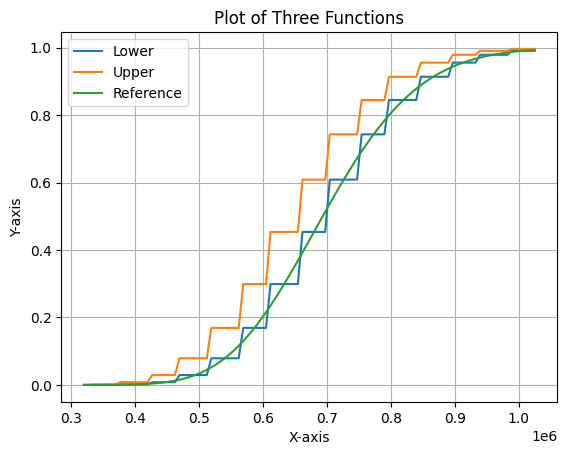

In [34]:
alpha1, alpha2, beta = 20, 15, 0.00005
d1 = Gamma(alpha1, beta)
d2 = Gamma(alpha2, beta)

reference = Gamma(alpha1 + alpha2, beta).cdf

fft_lower = convolve_distributions(d1, d2, steps=100, ref_points="upper")
fft_upper = convolve_distributions(d1, d2, steps=100, ref_points="lower")

lower = lambda x: fft_lower.cdf(x, method="scaled")
upper = lambda x: fft_upper.cdf(x, method="scaled")

s = fft_lower.ppf(0.001)
e = fft_upper.ppf(0.999)
buffer = (e - s)/20

# Define the range of values
values = np.linspace(s-buffer, e-buffer, 100)

# Evaluate the functions for all values
lower_y = lower(values)
upper_y = upper(values)
reference_y = reference(values)

# Create the plot
plt.plot(values, lower_y, label='Lower')
plt.plot(values, upper_y, label='Upper')
plt.plot(values, reference_y, label='Reference')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Three Functions')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()